In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
# Ensure it's parsed as datetime first
sp500.index = pd.to_datetime(sp500.index, utc=True)  # Forcefully makes it tz-aware

# Then remove the timezone
sp500.index = sp500.index.tz_convert(None)

# Now safely filter from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()

In [5]:
df = sp500.copy(deep=True)

In [6]:
# Apply standard single exponential smoothing (SES) to the Close price
alpha = 0.3  # smoothing factor (between 0 and 1)

df["SES_Close"] = df["Close"].ewm(alpha=alpha, adjust=False).mean()

In [7]:
# import pandas as pd
# import numpy as np
import ta  # technical analysis library

# # Assuming your DataFrame has 'SES_Close' and 'Volume' columns
# df = df.copy()

# # ========== TA-Based Features ==========

# 1. RSI (Relative Strength Index)
df['RSI'] = ta.momentum.RSIIndicator(close=df['SES_Close'], window=14).rsi()

# 2. MACD
macd = ta.trend.MACD(close=df['SES_Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

# 3. Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['SES_Close'])
df['Stoch_k'] = stoch.stoch()
df['Stoch_d'] = stoch.stoch_signal()

# # 4. Bollinger Bands
# boll = ta.volatility.BollingerBands(close=df['SES_Close'], window=20, window_dev=2)
# df['BB_upper'] = boll.bollinger_hband()
# df['BB_lower'] = boll.bollinger_lband()
# df['BB_percent'] = boll.bollinger_pband()

# 5. OBV (On-Balance Volume)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['SES_Close'], volume=df['Volume']).on_balance_volume()

# ========== Lag Features ==========
df['Lag_1'] = df['SES_Close'].shift(1)
df['Lag_2'] = df['SES_Close'].shift(2)
df['Lag_3'] = df['SES_Close'].shift(3)
df['Lag_4'] = df['SES_Close'].shift(4)
df['Lag_5'] = df['SES_Close'].shift(5)
df['Lag_10'] = df['SES_Close'].shift(10)
# # # ========== Shift all features to prevent leakage ==========
# # # Get list of all features excluding Target
# feature_cols = [col for col in df.columns if col not in ['Target']]

# # # Shift all features by 1 step (to make sure they only use past data)
# # df[feature_cols] = df[feature_cols].shift(1)

# # # Drop any rows with NaNs (from rolling windows, shifting, etc.)
# # df = df.dropna().reset_index(drop=True)


# Example on 'SES_Close' column
# Define window periods you want
sma_periods = [5, 10, 20,50]
ema_periods = [5, 10, 20]

for period in sma_periods:
    df[f'SMA_{period}'] = df['SES_Close'].rolling(window=period).mean()

for period in ema_periods:
    df[f'EMA_{period}'] = df['SES_Close'].ewm(span=period, adjust=False).mean()


df['Net_Change_2d'] = df['Close'] - df['Close'].shift(2)
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_10d'] = df['Daily_Return'].rolling(window=10).std()

In [8]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'SES_Close', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'Stoch_k',
       'Stoch_d', 'OBV', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_10',
       'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20',
       'Net_Change_2d', 'Daily_Return', 'Volatility_10d'],
      dtype='object')

In [9]:




# # Calculate moving averages
# df['MA10'] = df['SES_Close'].rolling(window=10).mean()
# df['MA50'] = df['SES_Close'].rolling(window=50).mean()
# df['EMA20'] = df['SES_Close'].ewm(span=20, adjust=False).mean()

# Create binary target column

num_days=10
df['Target'] = (df['SES_Close'].shift(-num_days) > df['SES_Close']).astype(int)

# Drop the last row (no label for the last day)
df = df.dropna()

In [10]:
df.drop(['Dividends','Stock Splits'],axis=1, inplace=True)

In [11]:
df

,Open,High,Low,Close,Volume,SES_Close,RSI,MACD,MACD_signal,MACD_diff,...,SMA_10,SMA_20,SMA_50,EMA_5,EMA_10,EMA_20,Net_Change_2d,Daily_Return,Volatility_10d,Target
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-13 05:00:00,338.670013,338.670013,335.359985,336.000000,145440000,337.041381,62.673705,0.344091,-0.990848,1.334939,...,334.181017,332.194241,336.811937,336.299812,334.760170,333.676823,-1.929993,-0.007884,0.007282,1
1990-03-14 05:00:00,336.000000,337.630005,334.929993,336.869995,145060000,336.989965,62.398395,0.530391,-0.686600,1.216992,...,334.925912,332.474820,336.357936,336.529863,335.165587,333.992360,-1.800018,0.002589,0.007206,1
1990-03-15 05:00:00,336.869995,338.910004,336.869995,338.070007,144410000,337.313978,63.486910,0.696156,-0.410049,1.106205,...,335.607238,332.762125,335.915996,336.791235,335.556204,334.308705,2.070007,0.003562,0.007229,1
1990-03-16 05:00:00,338.070007,341.910004,338.070007,341.910004,222520000,338.692786,67.763538,0.928085,-0.142422,1.070508,...,336.275267,333.068538,335.524077,337.425085,336.126491,334.726236,5.040009,0.011359,0.007587,1
1990-03-19 05:00:00,341.910004,343.760010,339.119995,343.529999,142300000,340.143950,71.541538,1.214983,0.129059,1.085924,...,337.036587,333.445177,335.197714,338.331373,336.856938,335.242209,5.459991,0.004738,0.007173,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01 04:00:00,6187.250000,6210.779785,6177.970215,6198.009766,6275310000,6153.578444,86.279675,78.867944,75.201746,3.666197,...,6052.804447,6014.371225,5807.269334,6107.920644,6069.689027,6011.863623,24.939941,-0.001119,0.006112,0
2025-07-02 04:00:00,6193.879883,6227.600098,6188.290039,6227.419922,5645710000,6175.730888,87.403539,82.451555,76.651708,5.799847,...,6070.043811,6026.832106,5825.404587,6130.524058,6088.969365,6027.470029,22.469727,0.004745,0.004722,0
2025-07-03 04:00:00,6246.459961,6284.649902,6246.459961,6279.350098,3378110000,6206.816651,88.791057,86.799385,78.681243,8.118141,...,6091.065765,6040.182823,5844.048806,6155.954922,6110.396144,6044.550660,81.340332,0.008339,0.004631,0


In [12]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["SES_Close"] / rolling_averages["SES_Close"] #ratio of close values. Today's close value with rolling average 
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"] #how many days in the horizon, price went up.
    
    new_predictors+= [ratio_column, trend_column]

In [13]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SES_Close', 'RSI', 'MACD',
       'MACD_signal', 'MACD_diff', 'Stoch_k', 'Stoch_d', 'OBV', 'Lag_1',
       'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_10', 'SMA_5', 'SMA_10',
       'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'Net_Change_2d',
       'Daily_Return', 'Volatility_10d', 'Target', 'Close_Ratio_2', 'Trend_2',
       'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60',
       'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000'],
      dtype='object')

In [14]:
new_features = [ 'SES_Close','Close_Ratio_2','Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250','MACD','RSI','Stoch_d','OBV','Lag_1',
               'Lag_2','Lag_3','Lag_4','Lag_5','Lag_10','SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'Net_Change_2d']

In [15]:
for col in new_features:
    df[col] = df[col].shift(1)

In [16]:
df.dropna(inplace=True)

In [17]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[new_features])

In [18]:
# Create sequences
def create_sequences(data, labels, look_back=100):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(labels[i+look_back])
    return np.array(X), np.array(y)

look_back = 30
X, y = create_sequences(scaled_features, df['Target'].values, look_back)


# “Will the price go up 5 (n days) days from today, based on the last 30 days of features?”


In [19]:
len(X)

7865

In [20]:
# Train/test split
total_samples = len(X)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

In [21]:
X_train.shape

(5505, 30, 27)

In [22]:
y_train.shape

(5505,)

In [23]:
X_val.shape

(1179, 30, 27)

In [24]:
y_val.shape

(1179,)

In [25]:


from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    LSTM(32, input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6518 - loss: 0.6722 - val_accuracy: 0.7455 - val_loss: 0.6560
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7369 - loss: 0.6012 - val_accuracy: 0.8109 - val_loss: 0.4942
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7640 - loss: 0.5570 - val_accuracy: 0.8244 - val_loss: 0.5227
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7902 - loss: 0.5224 - val_accuracy: 0.8312 - val_loss: 0.5190
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7950 - loss: 0.5124 - val_accuracy: 0.8321 - val_loss: 0.4982
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7909 - loss: 0.5087 - val_accuracy: 0.8355 - val_loss: 0.4669
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7938 - loss: 0.5061 - val_accuracy: 0.8372 - val_loss: 0.4714
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7960 - loss: 0.5056 - val_accuracy: 0.8397 - v

In [27]:
# Predict and evaluate
# Get predicted probabilities (sigmoid output)
y_probs = model.predict(X_test).flatten()  # returns probability of class 1

# Apply threshold manually (e.g., 0.6)
y_pred = (y_probs > 0.5).astype(int)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))




37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[340  56]
 [217 568]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.86      0.71       396
           1       0.91      0.72      0.81       785

    accuracy                           0.77      1181
   macro avg       0.76      0.79      0.76      1181
weighted avg       0.81      0.77      0.78      1181



In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")



Accuracy:    0.7688
Precision:   0.9103
Recall:      0.7236
Specificity: 0.8586
F1 Score:    0.8062


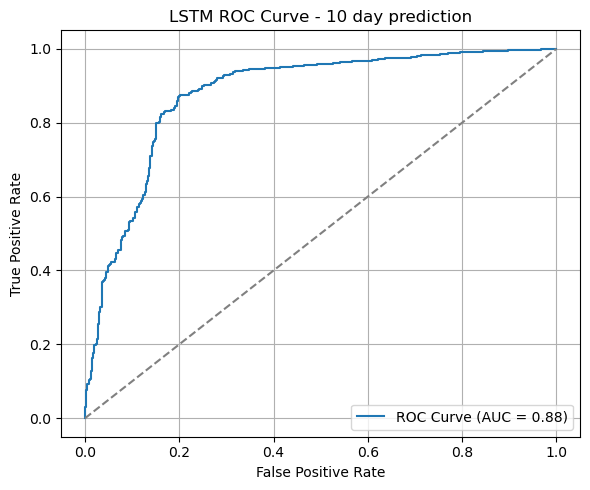

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'LSTM ROC Curve - {num_days} day prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_params = study.best_params

final_model = Sequential([
    LSTM(best_params['units'], input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(best_params['l2'])),
    Dropout(best_params['dropout']),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(best_params['l2']))
])

optimizer = Adam(learning_rate=best_params['lr'])

final_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
best_params

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

           Precision, recall, f1score, accuracy 
num_days5, 0.74, 0.73, 0.73, 0.73


num_days10 0.85, 0.85, 0.85, 0.85


num_days20 0.88, 0.88, 0.88, 0.88

num_days30 0.93

num_days40 0.91 

num_days50 0.95



In [ ]:
# y_pred is your prediction array of 0s and 1s
unique, counts = np.unique(y_pred, return_counts=True)

for val, count in zip(unique, counts):
    print(f"Number of {val}'s: {count}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted (Classification)')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Model is notidentifying 0s properly